In [110]:
import argparse
import os
import pathlib
import sys
import numpy as np
import torch
import imageio
import util
import bayes3d as b
from tqdm import tqdm

import nvdiffrast.torch as dr


In [111]:
max_iter           = 10000
repeats            = 1
log_interval       = 10
display_interval   = None
display_res        = 512
lr_base            = 0.01
lr_falloff         = 1.0
nr_base            = 1.0
nr_falloff         = 1e-4
grad_phase_start   = 0.5
resolution         = 256
out_dir            = None
log_fn             = None
mp4save_interval   = None
mp4save_fn         = None
use_opengl         = False

In [114]:
glctx = dr.RasterizeGLContext() #if use_opengl else dr.RasterizeCudaContext()
mvp = torch.tensor(np.matmul(util.projection(x=0.4), util.translate(0, 0, -3.5)).astype(np.float32), device='cuda')


In [119]:

#----------------------------------------------------------------------------
# Quaternion math.
#----------------------------------------------------------------------------

# Unit quaternion.
def q_unit():
    return np.asarray([1, 0, 0, 0], np.float32)

# Get a random normalized quaternion.
def q_rnd():
    u, v, w = np.random.uniform(0.0, 1.0, size=[3])
    v *= 2.0 * np.pi
    w *= 2.0 * np.pi
    return np.asarray([(1.0-u)**0.5 * np.sin(v), (1.0-u)**0.5 * np.cos(v), u**0.5 * np.sin(w), u**0.5 * np.cos(w)], np.float32)

# Get a random quaternion from the octahedral symmetric group S_4.
_r2 = 0.5**0.5
_q_S4 = [[ 1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [ 0.0, 0.0, 1.0, 0.0], [ 0.0, 0.0, 0.0, 1.0],
         [-0.5, 0.5, 0.5, 0.5], [-0.5,-0.5,-0.5, 0.5], [ 0.5,-0.5, 0.5, 0.5], [ 0.5, 0.5,-0.5, 0.5],
         [ 0.5, 0.5, 0.5, 0.5], [-0.5, 0.5,-0.5, 0.5], [ 0.5,-0.5,-0.5, 0.5], [-0.5,-0.5, 0.5, 0.5],
         [ _r2,-_r2, 0.0, 0.0], [ _r2, _r2, 0.0, 0.0], [ 0.0, 0.0, _r2, _r2], [ 0.0, 0.0,-_r2, _r2],
         [ 0.0, _r2, _r2, 0.0], [ _r2, 0.0, 0.0,-_r2], [ _r2, 0.0, 0.0, _r2], [ 0.0,-_r2, _r2, 0.0],
         [ _r2, 0.0, _r2, 0.0], [ 0.0, _r2, 0.0, _r2], [ _r2, 0.0,-_r2, 0.0], [ 0.0,-_r2, 0.0, _r2]]
def q_rnd_S4():
    return np.asarray(_q_S4[np.random.randint(24)], np.float32)

# Quaternion slerp.
def q_slerp(p, q, t):
    d = np.dot(p, q)
    if d < 0.0:
        q = -q
        d = -d
    if d > 0.999:
        a = p + t * (q-p)
        return a / np.linalg.norm(a)
    t0 = np.arccos(d)
    tt = t0 * t
    st = np.sin(tt)
    st0 = np.sin(t0)
    s1 = st / st0
    s0 = np.cos(tt) - d*s1
    return s0*p + s1*q

# Quaterion scale (slerp vs. identity quaternion).
def q_scale(q, scl):
    return q_slerp(q_unit(), q, scl)

# Quaternion product.
def q_mul(p, q):
    s1, V1 = p[0], p[1:]
    s2, V2 = q[0], q[1:]
    s = s1*s2 - np.dot(V1, V2)
    V = s1*V2 + s2*V1 + np.cross(V1, V2)
    return np.asarray([s, V[0], V[1], V[2]], np.float32)

# Angular difference between two quaternions in degrees.
def q_angle_deg(p, q):
    p = p.detach().cpu().numpy()
    q = q.detach().cpu().numpy()
    d = np.abs(np.dot(p, q))
    d = min(d, 1.0)
    return np.degrees(2.0 * np.arccos(d))

# Quaternion product
def q_mul_torch(p, q):
    a = p[0]*q[0] - p[1]*q[1] - p[2]*q[2] - p[3]*q[3]
    b = p[0]*q[1] + p[1]*q[0] + p[2]*q[3] - p[3]*q[2]
    c = p[0]*q[2] + p[2]*q[0] + p[3]*q[1] - p[1]*q[3]
    d = p[0]*q[3] + p[3]*q[0] + p[1]*q[2] - p[2]*q[1]
    return torch.stack([a, b, c, d])

# Convert quaternion to 4x4 rotation matrix.
def q_to_mtx(q):
    r0 = torch.stack([1.0-2.0*q[1]**2 - 2.0*q[2]**2, 2.0*q[0]*q[1] - 2.0*q[2]*q[3], 2.0*q[0]*q[2] + 2.0*q[1]*q[3]])
    r1 = torch.stack([2.0*q[0]*q[1] + 2.0*q[2]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[2]**2, 2.0*q[1]*q[2] - 2.0*q[0]*q[3]])
    r2 = torch.stack([2.0*q[0]*q[2] - 2.0*q[1]*q[3], 2.0*q[1]*q[2] + 2.0*q[0]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[1]**2])
    rr = torch.transpose(torch.stack([r0, r1, r2]), 1, 0)
    rr = torch.cat([rr, torch.tensor([[0], [0], [0]], dtype=torch.float32).cuda()], dim=1) # Pad right column.
    rr = torch.cat([rr, torch.tensor([[0, 0, 0, 1]], dtype=torch.float32).cuda()], dim=0)  # Pad bottom row.
    return rr

# Transform vertex positions to clip space
def transform_pos(mtx, pos):
    t_mtx = torch.from_numpy(mtx).cuda() if isinstance(mtx, np.ndarray) else mtx
    # (x,y,z) -> (x,y,z,1)
    posw = torch.cat([pos, torch.ones([pos.shape[0], 1]).cuda()], axis=1)
    return torch.matmul(posw, t_mtx.t())[None, ...]

def render(glctx, mtx, pos, pos_idx, col, col_idx, resolution: int):
    # Setup TF graph for reference.
    depth_ = pos[..., 2:3]
    depth = torch.tensor([[[(z_val/1)] for z_val in depth_.squeeze()]], dtype=torch.float32).cuda()
    pos_clip    = transform_pos(mtx, pos)
    rast_out, _ = dr.rasterize(glctx, pos_clip, pos_idx, resolution=[resolution, resolution])
    color   , _ = dr.interpolate(depth, rast_out, pos_idx)
    # color       = dr.antialias(color, rast_out, pos_clip, pos_idx)
    return color
    # return rast_out[:,:,:,2:3]


In [120]:
datadir = "/home/nishadgothoskar/bayes3d/nvdiffrast/samples/data/"
with np.load(f'{datadir}/cube_p.npz') as f:
    pos_idx, pos, col_idx, col = f.values()
print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))

# Some input geometry contains vertex positions in (N, 4) (with v[:,3]==1).  Drop
# the last column in that case.
if pos.shape[1] == 4: pos = pos[:, 0:3]

# Create position/triangle index tensors
pos_idx = torch.from_numpy(pos_idx.astype(np.int32)).cuda()
vtx_pos = torch.from_numpy(pos.astype(np.float32)).cuda()
col_idx = torch.from_numpy(col_idx.astype(np.int32)).cuda()
vtx_col = torch.from_numpy(col.astype(np.float32)).cuda()
print(pos_idx.shape, vtx_pos.shape, col_idx.shape, vtx_col.shape)
print(vtx_col)

# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# idx = 14
# mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
# m = b.utils.load_mesh(mesh_path)
# m = b.utils.scale_mesh(m, 1.0/100.0)

# vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
# pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
# col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
# vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()

Mesh has 12 triangles and 24 vertices.
torch.Size([12, 3]) torch.Size([24, 3]) torch.Size([12, 3]) torch.Size([6, 3])
tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.6470, 0.0000]], device='cuda:0')


In [123]:
img_target.shape

(256, 256, 1)

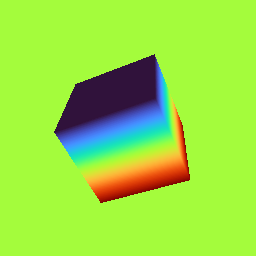

In [145]:
pose_target = torch.tensor(q_rnd(), device='cuda')
rast_target = render(glctx, torch.matmul(mvp, q_to_mtx(pose_target)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
img_target  = rast_target[0].detach().cpu().numpy()
b.hstack_images([
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])


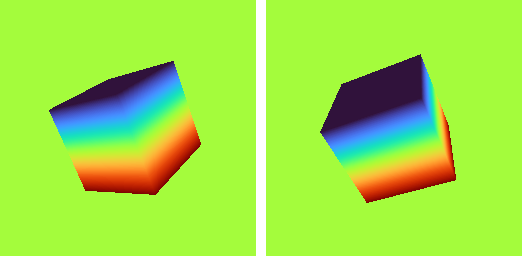

In [146]:
pose_init   = pose_target.cpu().numpy() + 0.3
pose_opt    = torch.tensor(pose_init / np.sum(pose_init**2)**0.5, dtype=torch.float32, device='cuda', requires_grad=True)
loss_best   = np.inf

rast_opt = render(glctx, torch.matmul(mvp, q_to_mtx(pose_opt)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
img_opt  = rast_opt[0].detach().cpu().numpy()
b.hstack_images([
    b.get_depth_image(img_opt[:,:,0]* 255.0) ,
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])


In [147]:
optimizer = torch.optim.Adam([pose_opt], betas=(0.9, 0.999), lr=lr_base)
images = []

for _ in tqdm(range(200)):
    noise = q_unit()
    pose_total_opt = q_mul_torch(pose_opt, noise)
    mtx_total_opt  = torch.matmul(mvp, q_to_mtx(pose_total_opt))
    color_opt      = render(glctx, mtx_total_opt, vtx_pos, pos_idx, vtx_col, col_idx, resolution)
    
    diff = (rast_opt - rast_target)**2 # L2 norm.
    diff = torch.tanh(5.0 * torch.max(diff, dim=-1)[0])
    loss = torch.mean(diff)
    loss_val = float(loss)
    
    if (loss_val < loss_best) and (loss_val > 0.0):
        loss_best = loss_val
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(pose_opt.grad)
    
    with torch.no_grad():
        pose_opt /= torch.sum(pose_opt**2)**0.5
    
    rast_opt = render(glctx, torch.matmul(mvp, q_to_mtx(pose_opt)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
    img_opt  = rast_opt[0].detach().cpu().numpy()
    images.append(
b.hstack_images([
    b.get_depth_image(img_opt[:,:,0]* 255.0) ,
    b.get_depth_image(img_target[:,:,0]* 255.0) ,
])
    )

  4%|███████▎                                                                                                                                                                                | 8/200 [00:00<00:02, 74.89it/s]

tensor([-0.2559,  0.0008, -0.0413,  0.0110], device='cuda:0')
tensor([-0.2312,  0.0031, -0.0292,  0.0156], device='cuda:0')
tensor([-0.2063,  0.0039, -0.0170,  0.0189], device='cuda:0')
tensor([-0.1808,  0.0035, -0.0041,  0.0214], device='cuda:0')
tensor([-0.1535,  0.0015,  0.0096,  0.0234], device='cuda:0')
tensor([-0.1256, -0.0010,  0.0222,  0.0230], device='cuda:0')
tensor([-0.1001, -0.0031,  0.0305,  0.0198], device='cuda:0')
tensor([-0.0774, -0.0039,  0.0336,  0.0142], device='cuda:0')
tensor([-0.0579, -0.0034,  0.0321,  0.0064], device='cuda:0')
tensor([-0.0390, -0.0013,  0.0281, -0.0017], device='cuda:0')
tensor([-0.0231,  0.0012,  0.0224, -0.0103], device='cuda:0')
tensor([-0.0091,  0.0041,  0.0166, -0.0175], device='cuda:0')
tensor([ 0.0025,  0.0066,  0.0118, -0.0233], device='cuda:0')
tensor([ 0.0124,  0.0084,  0.0086, -0.0271], device='cuda:0')
tensor([ 0.0198,  0.0097,  0.0067, -0.0293], device='cuda:0')
tensor([ 0.0251,  0.0110,  0.0057, -0.0300], device='cuda:0')


 16%|█████████████████████████████▎                                                                                                                                                         | 32/200 [00:00<00:02, 76.32it/s]

tensor([ 0.0282,  0.0110,  0.0057, -0.0296], device='cuda:0')
tensor([ 0.0302,  0.0118,  0.0063, -0.0280], device='cuda:0')
tensor([ 0.0298,  0.0116,  0.0071, -0.0257], device='cuda:0')
tensor([ 0.0284,  0.0111,  0.0084, -0.0232], device='cuda:0')
tensor([ 0.0256,  0.0110,  0.0101, -0.0198], device='cuda:0')
tensor([ 0.0225,  0.0097,  0.0120, -0.0165], device='cuda:0')
tensor([ 0.0182,  0.0088,  0.0137, -0.0130], device='cuda:0')
tensor([ 0.0136,  0.0080,  0.0149, -0.0095], device='cuda:0')
tensor([ 0.0091,  0.0068,  0.0166, -0.0061], device='cuda:0')
tensor([ 0.0044,  0.0054,  0.0176, -0.0030], device='cuda:0')
tensor([ 0.0002,  0.0038,  0.0184, -0.0003], device='cuda:0')
tensor([-0.0036,  0.0017,  0.0188,  0.0020], device='cuda:0')
tensor([-0.0071, -0.0007,  0.0186,  0.0037], device='cuda:0')
tensor([-0.0102, -0.0030,  0.0179,  0.0049], device='cuda:0')
tensor([-0.0141, -0.0048,  0.0161,  0.0051], device='cuda:0')
tensor([-0.0175, -0.0057,  0.0131,  0.0051], device='cuda:0')


 24%|███████████████████████████████████████████▉                                                                                                                                           | 48/200 [00:00<00:01, 77.07it/s]

tensor([-0.0203, -0.0051,  0.0096,  0.0049], device='cuda:0')
tensor([-0.0222, -0.0039,  0.0059,  0.0047], device='cuda:0')
tensor([-0.0228, -0.0043,  0.0007,  0.0041], device='cuda:0')
tensor([-0.0221, -0.0047, -0.0066,  0.0033], device='cuda:0')
tensor([-0.0208, -0.0040, -0.0132,  0.0027], device='cuda:0')
tensor([-0.0196, -0.0033, -0.0185,  0.0021], device='cuda:0')
tensor([-0.0182, -0.0017, -0.0222,  0.0017], device='cuda:0')
tensor([-0.0170, -0.0004, -0.0241,  0.0014], device='cuda:0')
tensor([-0.0162,  0.0013, -0.0246,  0.0010], device='cuda:0')
tensor([-0.0152,  0.0019, -0.0232,  0.0009], device='cuda:0')
tensor([-0.0142,  0.0015, -0.0204,  0.0010], device='cuda:0')
tensor([-0.0131,  0.0005, -0.0166,  0.0010], device='cuda:0')
tensor([-0.0119, -0.0005, -0.0120,  0.0012], device='cuda:0')
tensor([-0.0109, -0.0015, -0.0071,  0.0013], device='cuda:0')
tensor([-0.0094, -0.0019, -0.0024,  0.0015], device='cuda:0')
tensor([-0.0080, -0.0021,  0.0014,  0.0016], device='cuda:0')


 32%|██████████████████████████████████████████████████████████▌                                                                                                                            | 64/200 [00:00<00:01, 77.14it/s]

tensor([-0.0060, -0.0026,  0.0038,  0.0014], device='cuda:0')
tensor([-0.0038, -0.0028,  0.0053,  0.0012], device='cuda:0')
tensor([-0.0019, -0.0023,  0.0060,  0.0010], device='cuda:0')
tensor([-7.3739e-06, -9.9312e-04,  6.3663e-03,  7.7609e-04], device='cuda:0')
tensor([0.0013, 0.0010, 0.0061, 0.0004], device='cuda:0')
tensor([ 0.0025,  0.0022,  0.0057, -0.0001], device='cuda:0')
tensor([ 0.0040,  0.0033,  0.0053, -0.0005], device='cuda:0')
tensor([ 0.0056,  0.0034,  0.0053, -0.0009], device='cuda:0')
tensor([ 0.0070,  0.0031,  0.0054, -0.0012], device='cuda:0')
tensor([ 0.0084,  0.0020,  0.0054, -0.0014], device='cuda:0')
tensor([ 0.0095,  0.0009,  0.0057, -0.0016], device='cuda:0')
tensor([ 0.0102, -0.0004,  0.0057, -0.0017], device='cuda:0')
tensor([ 0.0105, -0.0010,  0.0053, -0.0017], device='cuda:0')
tensor([ 0.0102, -0.0009,  0.0046, -0.0017], device='cuda:0')
tensor([ 0.0095, -0.0009,  0.0038, -0.0016], device='cuda:0')
tensor([ 8.3105e-03, -8.3818e-05,  2.7615e-03, -1.4694e-03

 40%|█████████████████████████████████████████████████████████████████████████▏                                                                                                             | 80/200 [00:01<00:01, 76.90it/s]

tensor([ 0.0069,  0.0006,  0.0016, -0.0014], device='cuda:0')
tensor([ 0.0052,  0.0011,  0.0002, -0.0011], device='cuda:0')
tensor([ 0.0035,  0.0016, -0.0009, -0.0009], device='cuda:0')
tensor([ 0.0020,  0.0010, -0.0020, -0.0006], device='cuda:0')
tensor([ 0.0007, -0.0003, -0.0030, -0.0004], device='cuda:0')
tensor([-0.0007, -0.0011, -0.0038, -0.0002], device='cuda:0')
tensor([-2.2549e-03, -1.4987e-03, -4.3304e-03, -6.4264e-06], device='cuda:0')
tensor([-0.0038, -0.0013, -0.0046,  0.0002], device='cuda:0')
tensor([-0.0051, -0.0010, -0.0045,  0.0005], device='cuda:0')
tensor([-0.0062, -0.0005, -0.0040,  0.0008], device='cuda:0')
tensor([-7.2245e-03,  9.2710e-05, -3.3266e-03,  9.2961e-04], device='cuda:0')
tensor([-0.0079,  0.0004, -0.0024,  0.0011], device='cuda:0')
tensor([-0.0081,  0.0007, -0.0014,  0.0012], device='cuda:0')
tensor([-0.0077,  0.0008, -0.0004,  0.0013], device='cuda:0')
tensor([-0.0071,  0.0003,  0.0007,  0.0013], device='cuda:0')
tensor([-0.0061, -0.0005,  0.0009,  0.

 48%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 96/200 [00:01<00:01, 76.85it/s]

tensor([-0.0046, -0.0009,  0.0016,  0.0010], device='cuda:0')
tensor([-0.0033, -0.0010,  0.0021,  0.0007], device='cuda:0')
tensor([-0.0019, -0.0009,  0.0019,  0.0005], device='cuda:0')
tensor([-0.0005, -0.0008,  0.0017,  0.0003], device='cuda:0')
tensor([6.4903e-04, 7.3415e-04, 1.3679e-03, 4.5175e-05], device='cuda:0')
tensor([ 0.0017,  0.0013,  0.0011, -0.0002], device='cuda:0')
tensor([ 0.0027,  0.0013,  0.0009, -0.0005], device='cuda:0')
tensor([ 0.0037,  0.0010,  0.0008, -0.0007], device='cuda:0')
tensor([ 0.0044,  0.0004,  0.0006, -0.0008], device='cuda:0')
tensor([ 0.0049,  0.0004,  0.0010, -0.0009], device='cuda:0')
tensor([ 0.0051, -0.0011,  0.0011, -0.0010], device='cuda:0')
tensor([ 0.0050, -0.0013,  0.0006, -0.0010], device='cuda:0')
tensor([ 4.4445e-03, -9.2677e-04,  8.6849e-05, -9.0849e-04], device='cuda:0')
tensor([ 0.0034,  0.0003, -0.0003, -0.0007], device='cuda:0')
tensor([ 0.0022,  0.0013, -0.0008, -0.0006], device='cuda:0')
tensor([ 0.0012,  0.0012, -0.0011, -0.0004

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 112/200 [00:01<00:01, 77.04it/s]

tensor([ 0.0004,  0.0006, -0.0011, -0.0002], device='cuda:0')
tensor([-3.7601e-04, -3.6637e-04, -8.6069e-04, -4.3878e-05], device='cuda:0')
tensor([-0.0011, -0.0005, -0.0009,  0.0002], device='cuda:0')
tensor([-0.0018, -0.0007, -0.0008,  0.0003], device='cuda:0')
tensor([-0.0024, -0.0006, -0.0006,  0.0004], device='cuda:0')
tensor([-0.0029, -0.0004, -0.0004,  0.0005], device='cuda:0')
tensor([-3.2350e-03, -2.3353e-05, -2.3894e-04,  5.7792e-04], device='cuda:0')
tensor([-3.3521e-03,  2.7359e-04, -4.2863e-05,  6.0744e-04], device='cuda:0')
tensor([-0.0032,  0.0003,  0.0002,  0.0006], device='cuda:0')
tensor([-0.0029,  0.0003,  0.0004,  0.0006], device='cuda:0')
tensor([-2.2925e-03, -7.6300e-05,  2.2531e-04,  5.0980e-04], device='cuda:0')
tensor([-0.0016, -0.0003,  0.0002,  0.0004], device='cuda:0')
tensor([-0.0010, -0.0002,  0.0003,  0.0003], device='cuda:0')
tensor([-0.0003, -0.0003,  0.0004,  0.0001], device='cuda:0')
tensor([ 3.7881e-04, -1.0606e-04,  3.3335e-04, -3.4331e-05], device=

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 120/200 [00:01<00:01, 77.08it/s]

tensor([ 1.4258e-03,  7.0648e-04,  4.9159e-05, -2.3869e-04], device='cuda:0')
tensor([ 1.8322e-03,  3.8283e-04,  6.7995e-05, -3.2760e-04], device='cuda:0')
tensor([ 2.0460e-03, -3.2689e-05,  9.7338e-05, -3.8459e-04], device='cuda:0')
tensor([ 0.0022, -0.0004,  0.0002, -0.0004], device='cuda:0')
tensor([ 2.0267e-03, -3.8719e-04,  5.0956e-05, -3.7905e-04], device='cuda:0')
tensor([ 1.8382e-03, -2.2894e-04, -3.5598e-05, -3.4118e-04], device='cuda:0')
tensor([ 0.0015,  0.0002, -0.0002, -0.0003], device='cuda:0')
tensor([ 0.0010,  0.0005, -0.0001, -0.0002], device='cuda:0')
tensor([ 0.0007,  0.0003, -0.0001, -0.0001], device='cuda:0')
tensor([ 2.3351e-04,  2.6916e-05, -8.2839e-05, -3.2599e-05], device='cuda:0')
tensor([-4.6144e-05, -1.2365e-04,  1.3451e-04,  4.0508e-05], device='cuda:0')
tensor([-0.0003, -0.0003,  0.0002,  0.0001], device='cuda:0')
tensor([-0.0006, -0.0001,  0.0003,  0.0002], device='cuda:0')
tensor([-8.2057e-04, -6.9623e-05,  2.2090e-04,  1.9704e-04], device='cuda:0')
tens

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 136/200 [00:01<00:00, 75.86it/s]

tensor([-9.8781e-04,  4.1462e-05,  1.9771e-05,  1.4922e-04], device='cuda:0')
tensor([-8.9026e-04,  4.9805e-05, -6.8191e-05,  1.1844e-04], device='cuda:0')
tensor([-7.2240e-04, -7.8642e-07, -1.0233e-04,  8.2972e-05], device='cuda:0')
tensor([-4.3540e-04, -7.4576e-05, -1.1308e-04,  9.2724e-05], device='cuda:0')
tensor([-2.6153e-04, -7.2015e-05, -1.2655e-04,  5.2063e-05], device='cuda:0')
tensor([-1.4120e-04, -3.6544e-05, -1.5129e-04,  1.5698e-05], device='cuda:0')
tensor([ 3.6705e-05, -6.0229e-05, -7.7033e-05, -1.9590e-05], device='cuda:0')
tensor([ 1.6907e-04,  1.1175e-04, -1.3066e-04, -4.0875e-05], device='cuda:0')
tensor([ 2.6657e-04,  9.8119e-05, -9.9534e-05, -5.8787e-05], device='cuda:0')
tensor([ 3.8842e-04,  1.8984e-05, -7.2246e-05, -7.5143e-05], device='cuda:0')
tensor([ 4.2333e-04, -4.0136e-05, -8.4105e-06, -7.8995e-05], device='cuda:0')
tensor([ 4.2184e-04, -5.0035e-05,  2.6487e-05, -7.4386e-05], device='cuda:0')
tensor([ 4.0398e-04, -4.4918e-05,  6.3325e-05, -6.7889e-05], dev

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 160/200 [00:02<00:00, 76.64it/s]

tensor([ 1.7527e-04,  2.1207e-04,  4.4606e-05, -1.3749e-05], device='cuda:0')
tensor([4.3813e-05, 6.9947e-05, 8.4975e-05, 7.9653e-06], device='cuda:0')
tensor([-1.0579e-05, -7.2311e-06,  1.0310e-04,  2.2827e-05], device='cuda:0')
tensor([-6.1031e-05, -8.0626e-05,  8.9906e-05,  2.9360e-05], device='cuda:0')
tensor([-8.5496e-05, -1.2573e-04,  7.2234e-05,  2.7547e-05], device='cuda:0')
tensor([-1.3495e-04, -7.9908e-05,  3.5880e-05,  4.2358e-05], device='cuda:0')
tensor([-1.8210e-04, -8.6873e-06, -1.6785e-05,  3.6068e-05], device='cuda:0')
tensor([-2.0606e-04,  8.1108e-05, -7.7264e-05, -4.3901e-06], device='cuda:0')
tensor([-1.8829e-04,  7.8727e-05, -8.6120e-05,  3.1458e-05], device='cuda:0')
tensor([-1.9493e-04,  7.2482e-05, -1.0207e-04, -7.7568e-06], device='cuda:0')
tensor([-1.0786e-04, -2.0660e-05, -5.3971e-05,  3.2914e-05], device='cuda:0')
tensor([-4.2970e-05, -7.9156e-05, -2.8377e-05,  2.8169e-05], device='cuda:0')
tensor([-2.7448e-05, -7.6845e-05, -2.9410e-05,  2.1859e-05], device=

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 168/200 [00:02<00:00, 75.44it/s]

tensor([4.7278e-05, 6.7334e-05, 5.0391e-06, 1.1447e-06], device='cuda:0')
tensor([ 7.6222e-05,  5.5392e-05,  4.4190e-05, -1.0589e-07], device='cuda:0')
tensor([ 8.6490e-05,  8.2555e-06,  5.0337e-05, -7.8272e-06], device='cuda:0')
tensor([ 1.0247e-04, -3.5631e-05,  4.3107e-05, -1.8661e-05], device='cuda:0')
tensor([ 1.7750e-04, -6.4647e-05,  5.4818e-05, -1.5529e-05], device='cuda:0')
tensor([ 1.1670e-04, -4.5205e-05,  3.8830e-05, -2.0243e-05], device='cuda:0')
tensor([ 1.1531e-04, -6.3010e-06,  7.5991e-06, -1.5915e-05], device='cuda:0')
tensor([ 1.0725e-04,  4.0397e-05,  3.1889e-06, -8.2325e-06], device='cuda:0')
tensor([ 7.3376e-05,  5.4971e-05, -3.7834e-05, -8.8222e-06], device='cuda:0')
tensor([ 6.4195e-05,  5.0498e-05, -3.5055e-05, -6.9499e-07], device='cuda:0')
tensor([ 1.6482e-05,  1.8938e-05, -3.1091e-05,  3.3043e-07], device='cuda:0')
tensor([ 3.0165e-05, -3.2211e-05, -1.1066e-05,  6.1248e-06], device='cuda:0')
tensor([-7.3508e-06, -5.3420e-05, -1.3738e-05,  2.6288e-06], device=

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 192/200 [00:02<00:00, 76.66it/s]

tensor([-7.1152e-05,  5.4861e-05, -1.6403e-05,  1.5718e-05], device='cuda:0')
tensor([-6.6965e-05,  4.1153e-05,  2.9012e-06,  1.8952e-05], device='cuda:0')
tensor([-2.6272e-05,  2.9220e-05,  1.2608e-05,  1.6643e-05], device='cuda:0')
tensor([ 9.1514e-06, -2.0804e-05,  3.2027e-05,  1.2736e-05], device='cuda:0')
tensor([ 5.6952e-05, -5.1383e-05,  2.0991e-05,  6.7134e-06], device='cuda:0')
tensor([ 7.3784e-05, -3.8545e-05,  1.4173e-05,  8.1616e-07], device='cuda:0')
tensor([ 4.4988e-05, -6.4255e-07,  2.6487e-06,  8.8204e-07], device='cuda:0')
tensor([ 5.0037e-05,  2.0879e-05, -8.9446e-07, -3.4171e-06], device='cuda:0')
tensor([ 4.4545e-05,  2.2976e-05, -2.6693e-06, -5.3157e-06], device='cuda:0')
tensor([ 4.5323e-05,  2.2877e-05, -2.6019e-06, -5.3086e-06], device='cuda:0')
tensor([ 6.2535e-05,  1.2014e-05, -4.1067e-06, -5.0230e-06], device='cuda:0')
tensor([ 6.3265e-05,  1.1659e-06,  2.0956e-06, -5.3807e-06], device='cuda:0')
tensor([ 2.7784e-05, -1.1584e-05,  5.7074e-06,  2.9748e-06], dev

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.41it/s]

tensor([ 6.6586e-06,  2.1616e-05, -1.2830e-05,  3.5946e-06], device='cuda:0')
tensor([ 5.8581e-06,  2.1722e-05, -1.2905e-05,  3.6034e-06], device='cuda:0')
tensor([ 1.1617e-05,  1.9575e-05, -1.1118e-05,  5.5048e-06], device='cuda:0')
tensor([ 4.5209e-05, -1.1716e-06,  1.4811e-06,  9.2272e-07], device='cuda:0')
tensor([ 3.4585e-05, -2.7018e-05,  6.1365e-06,  3.0763e-06], device='cuda:0')
tensor([ 3.3916e-05, -2.6943e-05,  6.0951e-06,  3.1225e-06], device='cuda:0')
tensor([ 2.2438e-05, -1.1279e-05,  3.9728e-06,  3.0409e-06], device='cuda:0')
tensor([-1.9822e-06,  2.8987e-05, -6.6874e-06,  7.1090e-06], device='cuda:0')


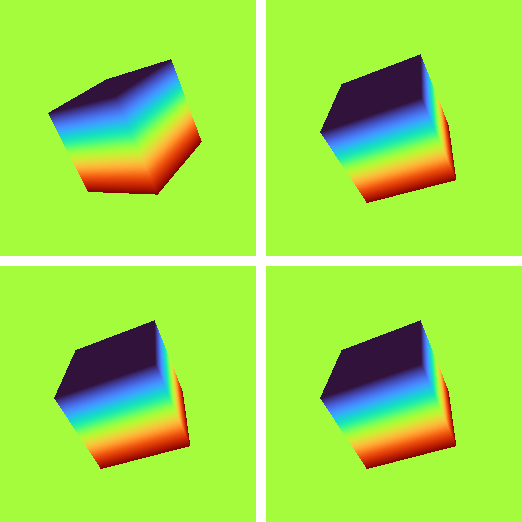

In [148]:
b.vstack_images([images[0],images[-1]])

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

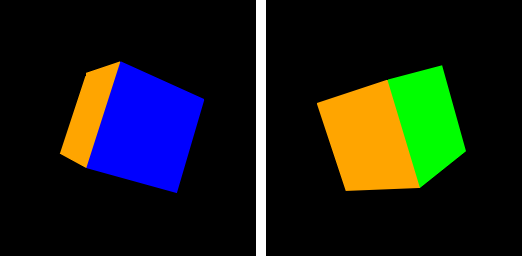